In this example, we will build a model to classify whether an image belongs to 'rock', 'paper', or 'scissor' category.

Dataset info: https://www.kaggle.com/drgfreeman/rockpaperscissors

1. Download the dataset from Kaggle (Note: You might require to create an account / login to your Kaggle account.)
2. Unzip the folder 
3. Create a folder named `dataset\rock-paper-scissor`in your home directory
4. Copy all folders named 'paper', 'rock', 'scissors' from the unzipped folder to `<HOME_DIRECTORY>/dataset/rock-paper-scissor`. 

In [18]:
!pip install tensorflow

  Using cached tensorflow-2.8.0-cp39-cp39-win_amd64.whl (438.0 MB)
  Using cached gast-0.5.3-py3-none-any.whl (19 kB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26 kB)
  Using cached tf_estimator_nightly-2.8.0.dev2021122109-py2.py3-none-any.whl (462 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached libclang-13.0.0-py2.py3-none-win_amd64.whl (13.9 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorflow_io_gcs_filesystem-0.24.0-cp39-cp39-win_amd64.whl (1.5 MB)
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
  Using cached protobuf-3.19.4-cp39-cp39-win_amd64.whl (895 kB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-an

In [12]:
from pathlib import Path
import numpy as np
import os

`pathlib.Path()` is a utility function that handles OS file paths. We are going to use it to access our home folder and list out all the files inside a folder. 

The home folder for Windows is usually your /User/Your-Name/

In [13]:
data_dir = os.path.join(Path.home(),'dataset','rock-paper-scissor')
print(data_dir)

C:\Users\Daddy\dataset\rock-paper-scissor


Next, we use the `.glob()` function to select all the PNG image type, and count the number of images.

In [14]:
data_dir = Path(data_dir)
image_count = len(list(data_dir.glob('*/*.png')))
image_count

2188

Now, we specify the input size for the input images, and some hyperparameters such as the batch size, and epochs (number of times a model observe the full training set).

In [15]:
IMAGE_HEIGHT = 100
IMAGE_WIDTH = 150

BATCH_SIZE = 32

EPOCHS = 10

TRAIN_PERC = 0.8

CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])

CLASS_NAMES

array(['paper', 'rock', 'scissors'], dtype='<U8')

Use 80% of the images for training, and the other for testing and validating

In [16]:
train_size = int(TRAIN_PERC * image_count)

test_size = int((1-TRAIN_PERC) * image_count)

# Create Data Pipeline

To create a data pipeline, We start by providing the list of image paths in the `tf.data.Dataset.list_files()` function

In [19]:
import tensorflow as tf

all_files = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [20]:
for f in all_files.take(5):
    print(f.numpy())

b'C:\\Users\\Daddy\\dataset\\rock-paper-scissor\\paper\\KAyKztBfGIWm4qN7.png'
b'C:\\Users\\Daddy\\dataset\\rock-paper-scissor\\paper\\QUcJ1QclQwOY50vY.png'
b'C:\\Users\\Daddy\\dataset\\rock-paper-scissor\\rock\\QSa6ILjZeRdKM5Fz.png'
b'C:\\Users\\Daddy\\dataset\\rock-paper-scissor\\paper\\UmipL2kv9TdDdryZ.png'
b'C:\\Users\\Daddy\\dataset\\rock-paper-scissor\\rock\\nW7S3LYj4C49mX06.png'


Shuffle the image paths and split them into a train set and a test set

In [21]:
all_files = all_files.shuffle(buffer_size = image_count)

train_files = all_files.take(train_size)

test_files = all_files.skip(train_size)

Next, we create functions to load the images into a tensor and process their corresponding labels.

The `parse_image()` function reads the image paths and output the tensor of desired size

The `get_label()` function extracts the labels and converts them into one-hot encoded format

In [23]:
def parse_img(img):
    # load the raw data from the file as a string
    img = tf.io.read_file(img)
    
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # resize the image to the desired size.
    return tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH])

In [22]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES

In [24]:
def process_path(file_path):
    label = get_label(file_path)
    
    img = parse_img(file_path)
    
    return img, label

In [25]:
train_dataset = train_files.map(process_path)

test_dataset = test_files.map(process_path)

In [26]:
for image, label in train_dataset.take(1):
    print("Image shape: ", image.numpy().shape)
    
    print("Label: ", label.numpy())

Image shape:  (100, 150, 3)
Label:  [False False  True]


Create batches of samples based on the BATCH_SIZE hyperparameter.

In [27]:
train_dataset_batch = train_dataset.batch(BATCH_SIZE)

test_dataset_batch = test_dataset.batch(BATCH_SIZE)

In [28]:
image_batch, label_batch = next(iter(train_dataset_batch))

In [51]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        
        plt.imshow(image_batch[n])
        
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        
        plt.axis('off')

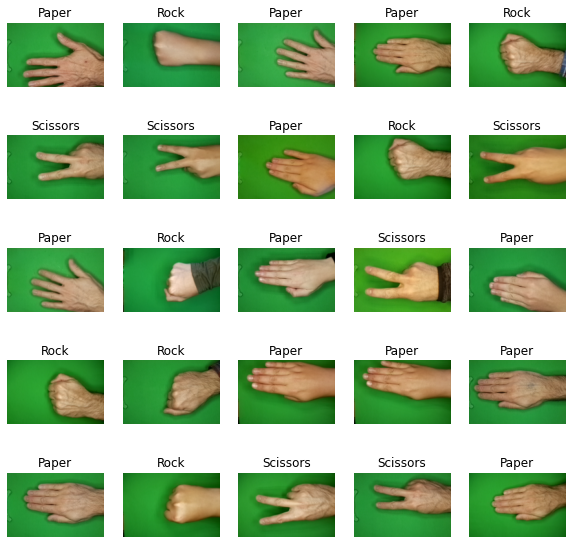

In [30]:
show_batch(image_batch.numpy(), label_batch.numpy())

# Model Training

We will define a model with 7 layers to classify the images

It is made up of 3 convolutional layers, 2 max pooling layers, and 2 dense layers.

In [31]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

model.add(tf.keras.layers.Flatten())

# Dense layers

model.add(tf.keras.layers.Dense(64, activation='relu'))

model.add(tf.keras.layers.Dense(3))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 148, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 34, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 45696)             0

Next, we define the training configuration, here we use 'adam' as the optimizer, cross entropy as the loss function, and accuracy as our evaluation metric

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

The `.fit` starts the training and all the training information will be stored in a 'history' variable.

In [34]:
history = model.fit(train_dataset_batch, epochs=EPOCHS, validation_data=test_dataset_batch)

Epoch 1/10
55/55 [==============================] - 44s 788ms/step - loss: 0.7787 - accuracy: 0.6697 - val_loss: 0.4399 - val_accuracy: 0.8379
Epoch 2/10
55/55 [==============================] - 43s 784ms/step - loss: 0.3100 - accuracy: 0.8983 - val_loss: 0.1575 - val_accuracy: 0.9452
Epoch 3/10
55/55 [==============================] - 41s 754ms/step - loss: 0.1401 - accuracy: 0.9509 - val_loss: 0.0921 - val_accuracy: 0.9658
Epoch 4/10
55/55 [==============================] - 43s 778ms/step - loss: 0.0776 - accuracy: 0.9760 - val_loss: 0.0866 - val_accuracy: 0.9726
Epoch 5/10
55/55 [==============================] - 46s 831ms/step - loss: 0.0379 - accuracy: 0.9874 - val_loss: 0.0279 - val_accuracy: 0.9977
Epoch 6/10
55/55 [==============================] - 46s 840ms/step - loss: 0.0540 - accuracy: 0.9811 - val_loss: 0.0843 - val_accuracy: 0.9635
Epoch 7/10
55/55 [==============================] - 49s 882ms/step - loss: 0.0585 - accuracy: 0.9737 - val_loss: 0.0378 - val_accuracy: 0.9909

We can use the information stored in the 'history' variable to visualize the trend of training loss.

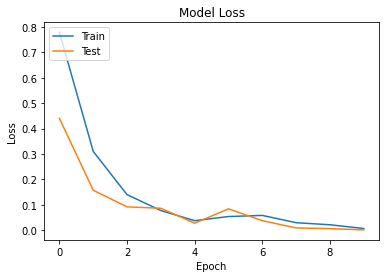

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Again, we plot a graph that shows the accuracy of model in each epoch using information from the 'history' variable.

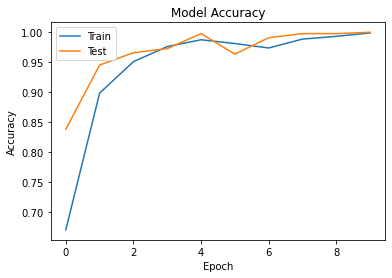

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluation

We can use the function provided by sklearn to produce a Confusion Matrix and a classification report to check the performance of our model.

In [37]:
test_pred = []
test_actual = []

for features, labels in test_dataset_batch:
    scores = model.predict(features)
    pred = np.argmax(scores, axis=1)
    
    test_pred = test_pred + list(pred)
    test_actual = test_actual + list(np.argmax(labels.numpy(), axis=1))

In [38]:
print(test_pred)

[2, 2, 1, 2, 0, 1, 2, 2, 2, 2, 1, 0, 1, 2, 2, 1, 0, 1, 0, 2, 0, 0, 1, 0, 1, 2, 2, 0, 2, 2, 2, 1, 1, 1, 2, 2, 0, 2, 0, 2, 1, 2, 1, 0, 2, 0, 0, 1, 2, 0, 0, 0, 2, 1, 0, 2, 0, 1, 2, 2, 0, 0, 1, 0, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 1, 1, 0, 2, 2, 2, 0, 0, 2, 0, 2, 0, 1, 2, 0, 1, 1, 0, 0, 0, 0, 2, 1, 0, 2, 1, 1, 0, 2, 0, 1, 1, 1, 1, 2, 1, 2, 0, 1, 2, 1, 2, 0, 2, 2, 1, 2, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 2, 1, 1, 1, 2, 1, 0, 0, 0, 0, 2, 2, 1, 2, 2, 1, 0, 2, 0, 1, 2, 0, 2, 1, 1, 2, 1, 2, 1, 2, 0, 0, 2, 1, 0, 0, 1, 1, 2, 2, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 2, 1, 2, 1, 2, 0, 1, 1, 2, 2, 1, 2, 0, 0, 2, 0, 0, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 0, 0, 0, 2, 1, 0, 0, 1, 1, 1, 2, 2, 0, 2, 1, 1, 1, 1, 0, 0, 1, 2, 2, 2, 0, 1, 1, 1, 0, 2, 2, 1, 0, 2, 0, 1, 1, 0, 2, 1, 2, 2, 1, 1, 2, 0, 0, 2, 1, 1, 2, 2, 0, 1, 2, 2, 1, 0, 1, 1, 0, 1, 0, 2, 1, 2, 2, 1, 1, 0, 2, 1, 2, 0, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 2, 1, 2, 0, 0, 1, 0, 0, 1, 2, 2, 1, 1, 1, 2, 0, 1, 0, 2, 2, 0, 

In [39]:
print(test_actual)

[2, 2, 1, 2, 0, 1, 2, 2, 2, 2, 1, 0, 1, 2, 2, 1, 0, 1, 0, 2, 0, 0, 1, 0, 1, 2, 2, 0, 2, 2, 2, 1, 1, 1, 2, 2, 0, 2, 0, 2, 1, 2, 1, 0, 2, 0, 0, 1, 2, 0, 0, 0, 2, 1, 0, 2, 0, 1, 2, 2, 0, 0, 1, 0, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 1, 1, 0, 2, 2, 2, 0, 0, 2, 0, 2, 0, 1, 2, 0, 1, 1, 0, 0, 0, 0, 2, 1, 0, 2, 1, 1, 0, 2, 0, 1, 1, 1, 1, 2, 1, 2, 0, 1, 2, 1, 2, 0, 2, 2, 1, 2, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 2, 1, 1, 1, 2, 1, 0, 0, 0, 0, 2, 2, 1, 2, 2, 1, 0, 2, 0, 1, 2, 0, 2, 1, 1, 2, 1, 2, 1, 2, 0, 0, 2, 1, 0, 0, 1, 1, 2, 2, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 2, 1, 2, 1, 2, 0, 1, 1, 2, 2, 1, 2, 0, 0, 2, 0, 0, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 0, 0, 0, 2, 1, 0, 0, 1, 1, 1, 2, 2, 0, 2, 1, 1, 1, 1, 0, 0, 1, 2, 2, 2, 0, 1, 1, 1, 0, 2, 2, 1, 0, 2, 0, 1, 1, 0, 2, 1, 2, 2, 1, 1, 2, 0, 0, 2, 1, 1, 2, 2, 0, 1, 2, 2, 1, 0, 1, 1, 0, 1, 0, 2, 1, 2, 2, 1, 1, 0, 2, 1, 2, 0, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 2, 1, 2, 0, 0, 1, 0, 0, 1, 2, 2, 1, 1, 1, 2, 0, 1, 0, 2, 2, 0, 

In [40]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(test_actual, test_pred))

[[137   0   0]
 [  0 149   0]
 [  0   0 152]]


In [41]:
print(classification_report(test_actual, test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       137
           1       1.00      1.00      1.00       149
           2       1.00      1.00      1.00       152

    accuracy                           1.00       438
   macro avg       1.00      1.00      1.00       438
weighted avg       1.00      1.00      1.00       438



# Inference

Once the model is trained, we can use it to predict a single image or batch of images.

We can use the `parse_img()` function that we define above to load the image, and pass them as a tensor to the `model.predict()` function.

In [42]:
inference_image = os.path.join(data_dir, 'rock', 'BvjXvNTvapIFq4bK.png')

In [43]:
test_image = parse_img(inference_image)

In [44]:
prediction_score = model.predict(np.expand_dims(test_image, 0))

In [45]:
prediction_score

array([[-3.2396395,  7.07956  , -8.186947 ]], dtype=float32)

When we perform a single sample prediction, the scores of each class are retrieved. In order to get the probability of the prediction, we squash the scores using the Softmax function and get the predictions probability.

In [46]:
softmax = tf.keras.layers.Softmax()
prediction_probability = softmax(prediction_score)

In [47]:
prediction_probability.numpy()

array([[3.2992415e-05, 9.9996674e-01, 2.3432906e-07]], dtype=float32)

Use `np.argmax()` function to get the index of element that contains the maximum value (the output with the highest probability).

In [48]:
prediction_class = np.argmax(prediction_probability, axis=1)

In [49]:
prediction_class

array([1], dtype=int64)

In [50]:
CLASS_NAMES[prediction_class]

array(['rock'], dtype='<U8')